# REDOR
Simulation of REDOR sequence

In [63]:
# Imports
from subprocess import Popen, PIPE
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
plt.rcParams.update({'font.size': 14})

In [26]:
class RunRead():
    def __init__(self):
        self.stdout=None
        self.stderr=None
    def __call__(self,script):
        with open('SIMPSON.tcl','w') as f:f.write(script)
        process = Popen(['simpson', 'SIMPSON.tcl', '-d'], stdout=PIPE, stderr=PIPE)
        self.stdout, self.stderr = [x.decode() for x in process.communicate()]            

        if len(self.stderr):print(self.stderr)
        # Collect the results
        with open('SIMPSON.fid','r') as f:
            while True:
                if 'DATA'==f.readline().strip():break
            S=[]
            while True:
                line=f.readline()
                if 'END'==line.strip():break
                S.append(complex(line.strip().split()[0])+complex(line.strip().split()[1])*1j)
        S=np.array(S)
        return S
run_read=RunRead()

In [9]:
script="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               64
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I1x
  method           direct
  crystal_file     rep144
  gamma_angles     100
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr      1e6/spin_rate
  variable rf      100000
  variable pi     0.5e6/rf
  variable dly     0.5*tr-pi
  variable dly_ref 0.5*(tr-pi)
}

proc pulseq {} {
  global par
  reset
  
  
  store 0
  store 1
  
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) y
  store 2
  
  reset
  pulse $par(pi) 0 x $par(rf) y
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  store 3
  
  reset
  delay $par(dly_ref)
  pulse $par(pi) $par(rf) x 0 x
  delay $par(dly_ref)
  store 4
  

  reset
  acq
  for {set i 1} {$i < $par(np)} {incr i} {
    prop 0
    prop 2
    store 0
    reset
    
    prop 1
    prop 3
    store 1
    reset
    
    prop 0
    prop 4
    prop 1
    acq
  }
}
proc main {} {
  global par

  set f [fsimpson]
  fsave $f $par(name).fid
}
"""

In [10]:
S=run_read(script)

(-0.1, 1.1)

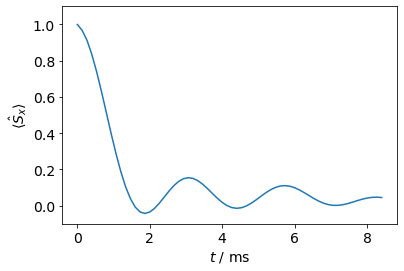

In [11]:
# Plot the results
x=2/15*np.arange(len(S))
fig,ax=plt.subplots()
ax.plot(x,S.real)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([-.1,1.1])

Dephasing occurs as $\hat{I}_x$ magnetization is converted into $2\hat{S}_z\hat{I}_y$, which is not directly observable.

Note that the average Hamiltonian depends significantly on both $\beta$ and $\gamma$ angles. We first set the $\gamma$ angle and vary the $\beta$ angle (note, there isn't a direct method to set $\gamma$, but we can reset the propagators to be part way throught the rotor period to get the same effect.

(-1.1, 1.1)

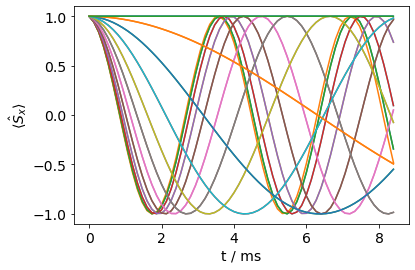

In [12]:
script1=script.replace('rep144','EulerAngle')
script1=script1.replace('gamma_angles     100','gamma_angles     1')
script1=script1.replace('reset','reset [expr $par(tr)/8]') #1/8 of the rotor period gives gamma=45
S=[]

beta0=np.linspace(0,90,23)
for beta in beta0:
    with open('EulerAngle.cry','w') as f:f.write(f'1\n0 {beta:.1f} 1')
    S.append(run_read(script1))
S=np.array(S)

ax=plt.plot(x,S.real.T)[0].axes
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([-1.1,1.1])

(-1.1, 1.1)

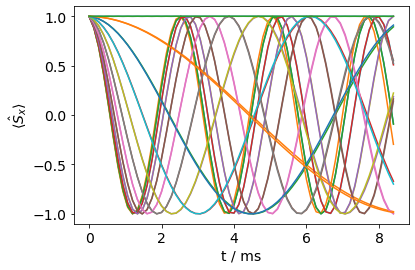

In [13]:
with open('EulerAngle.cry','w') as f:f.write(f'1\n0 {45:.1f} 1')  #beta set to 45 (alpha=0)
gamma0=np.linspace(0,180,23)
S=[]
for gamma in gamma0:
    script1=script.replace('rep144','EulerAngle')
    script1=script1.replace('gamma_angles     100','gamma_angles     1')
    script1=script1.replace('reset',f'reset [expr $par(tr)*{gamma}/360]') #Fraction of rotor period
    S.append(run_read(script1))
S=np.array(S)

ax=plt.plot(x,S.real.T)[0].axes
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([-1.1,1.1])

Where $\gamma=0$, there is no dephasing whatsoever, because both $\sin$ and $\cos$ terms average to zero during half of a rotor period. This type of sequence is *not* $\gamma$-encoded, because the sequence performance depends on the $\gamma$ angle (compare to CP, where the $\gamma$ angle does not affect the sequence efficiency).

The TEDOR experiment  expands on this concept, first transfering to $\hat{S}_z\hat{I}_y$ magnetization. This can be converted to $\hat{S}_y\hat{I}_z$ magnetization via $(\pi/2)_x$ pulses on both channels, followed by evolution on the $S$-spin, and finally reconversion back to $\hat{I}_x$ magnetization, via another set of $(\pi/2)$ pulses and another REDOR period. The buildup of magnetization  

In [18]:
script="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               32
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I1x
  method           direct
  crystal_file     rep144
  gamma_angles     100
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr      1e6/spin_rate
  variable rf      100000
  variable pi     0.5e6/rf
  variable pi2     0.25e6/rf
  variable dly     0.5*tr-pi
  variable dly_ref 0.5*(tr-pi)
  variable dly_conv 0.5*(tr-pi2)
}

proc pulseq {} {
  global par
  
  
  store 0
  store 1
  
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) y
  store 2
  
  reset
  pulse $par(pi) 0 x $par(rf) y
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  store 3
  
  reset
  delay $par(dly_ref)
  pulse $par(pi) $par(rf) x 0 x
  delay $par(dly_ref)
  store 4
  
  
  reset
  delay $par(dly_ref)
  pulse $par(pi2) 0 x $par(rf) x
  pulse $par(pi2) 0 x $par(rf) $par(ph)
  delay $par(dly_ref)
  store 5
  
  

  reset
  acq
  for {set i 1} {$i < $par(np)} {incr i} {
    reset
    prop 0
    prop 2
    store 0
    
    reset
    prop 1
    prop 3
    store 1
    
    reset
    prop 0
    prop 4
    prop 1
    
    prop 5
    
    prop 0
    prop 4
    prop 1
    
    acq
    
  }
}
proc main {} {
  global par

  set par(ph) 180.0
  set f [fsimpson]
  set par(ph) 0.0
  set g [fsimpson]
  fsub $f $g
  
  fsave $f $par(name).fid
}
"""

In [19]:
S=run_read(script)

(0.0, 0.6)

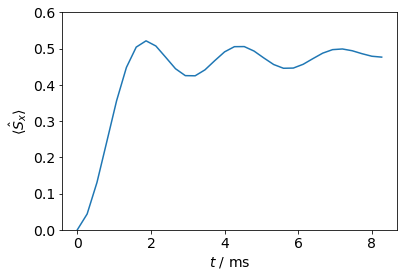

In [20]:
# Plot the results
x=4/15*np.arange(len(S))
fig,ax=plt.subplots()
ax.plot(x,S.real/2)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([0,.6])

A phase cycle on the $^{15}$N ensures that this magnetization has been transferred via the nitrogen, thus the TEDOR transfer proceeds through $\hat{S}_x\rightarrow2\hat{S}_y\hat{I}_z\rightarrow\hat{S}_x$

Does it matter if the first and second REDOR periods are rotor synchronized?

In [76]:
script="""
spinsys {
  channels 13C 15N
  nuclei   13C 15N
  dipole   1 2 895 0 0 0
}

par {
  variable index   1
  np               32
  spin_rate        15000
  proton_frequency 400e6
  start_operator   I1x
  detect_operator  I1x
  method           direct
  crystal_file     rep144
  gamma_angles     100
  sw               spin_rate/2
  variable tsw     1e6/sw
  variable tr      1e6/spin_rate
  variable rf      100000
  variable pi     0.5e6/rf
  variable pi2     0.25e6/rf
  variable dly     0.5*tr-pi
  variable dly_ref 0.5*(tr-pi)
  variable dly_conv 0.5*(tr-pi2)
  variable dly_async 1.25*tr
}

proc pulseq {} {
  global par
  
  
  store 0
  store 1
  reset $par(dly_async)
  store 10
  store 11
  
  reset
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) y
  store 2
  
  reset
  pulse $par(pi) 0 x $par(rf) y
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  store 3
  
  reset
  delay $par(dly_ref)
  pulse $par(pi) $par(rf) x 0 x
  delay $par(dly_ref)
  store 4
  
  
  reset
  delay $par(dly_ref)
  pulse $par(pi2) $par(rf) x $par(rf) x
  delay $par(dly_async)
  pulse $par(pi2) $par(rf) -x $par(rf) $par(ph)
  delay $par(dly_ref)
  store 5
  
  reset $par(dly_async)
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) y
  store 12
  
  reset $par(dly_async)
  pulse $par(pi) 0 x $par(rf) y
  delay $par(dly)
  pulse $par(pi) 0 x $par(rf) x
  delay $par(dly)
  store 13
  
  reset $par(dly_async)
  delay $par(dly_ref)
  pulse $par(pi) $par(rf) x 0 x
  delay $par(dly_ref)
  store 14
  
  
  

  reset
  acq
  for {set i 1} {$i < $par(np)} {incr i} {
    reset
    prop 0
    prop 2
    store 0
    
    reset
    prop 1
    prop 3
    store 1
    
    reset $par(dly_async)
    prop 10
    prop 12
    store 10
    
    reset $par(dly_async)
    prop 11
    prop 13
    store 11
    
    reset
    prop 0
    prop 4
    prop 1
    
    prop 5
    
    prop 10
    prop 14
    prop 11
    
    acq
    
  }
}
proc main {} {
  global par

  set par(ph) 180.0
  set f [fsimpson]
  set par(ph) 0.0
  set g [fsimpson]
  fsub $f $g
  
  fsave $f $par(name).fid
}
"""

In [77]:
S=run_read(script)

(-0.6, 0.6)

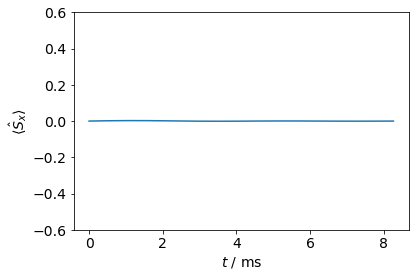

In [78]:
# Plot the results
x=4/15*np.arange(len(S))
fig,ax=plt.subplots()
ax.plot(x,S.real/2)
ax.set_xlabel(r'$t$ / ms')
ax.set_ylabel(r'$\langle \hat{S}_x\rangle$')
ax.set_ylim([-.6,.6])